<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/Assignments/Assignment8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 8

**Submission deadline:**
* **lab session in the week 12-16.12.22**

**Points: 2+2+2=6 points**


In [422]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.
!pip install -q gdown httpimport

In [423]:
# Standard IPython notebook imports
import itertools
import io
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as sopt
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn import datasets
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc

import httpimport

# In this way we can import functions straight from github
with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    from common.gradients import check_gradient
    from common.plotting import plot_mat

sns.set_style("whitegrid")

# More of Gradient Descent

## Linear regression example

In [424]:
# Repeat notebook initialization and data loading

import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
import sklearn.neighbors
import seaborn as sns
import matplotlib.pyplot as plt

iris = sklearn.datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = pd.Categorical(iris.target_names[iris.target])

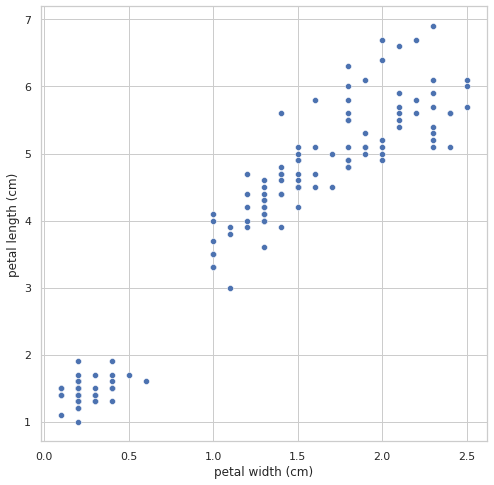

In [425]:
reg_feature='petal width (cm)'
reg_target='petal length (cm)'

# plot the length-widt relation
sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
sns.set(rc={'figure.figsize':(8,8)})

In [426]:
X = iris_df[[reg_feature]]
y = np.asarray(iris_df[reg_target]).reshape(-1,1)

In [427]:

class LinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        n = X.shape[0]
        E = X @ Theta - y
        return (2./n) * X.T @ E

    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta = np.zeros((X.shape[1], 1)) #sane starting Theta

        alpha=1e-2
        for _ in range(1000):
            grad_Theta = self.grad(Theta,X,y)
            Theta = Theta - alpha*grad_Theta
            
        self.ThetaOpt = Theta
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [428]:
model = LinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

[[1.0880229 ]
 [2.22698227]]


In [429]:
y_pred = model.predict(X)

In [430]:
def mse(y_true, y_pred):
    return ((y_pred - y_true)**2).mean()

In [431]:
mse(y, y_pred)

0.22563757914960603

In [432]:
def plot_LR(a,b):
    # plot the length-widt relation
    sns.scatterplot(x=reg_feature, y=reg_target, data=iris_df)
    sns.set(rc={'figure.figsize':(8,8)})

    # plot the proposed relationship
    length_bounds = np.array(plt.xlim())
    width_predictions = a * length_bounds + b

    plt.plot(length_bounds, width_predictions, color='r')
    _ = plt.text(0.8, 1.2, f"$y = x \cdot {float(a):0.2} + {float(b):0.2}$")

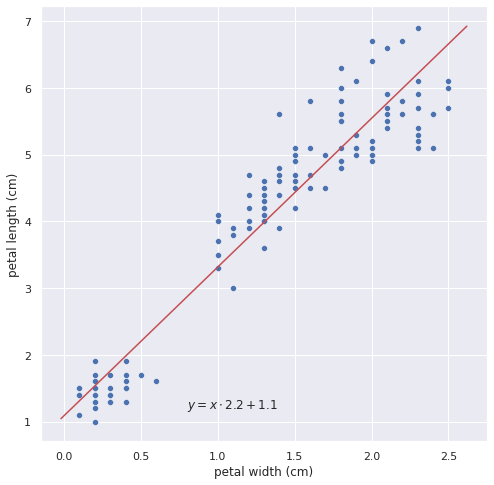

In [433]:
plot_LR(model.ThetaOpt[1], model.ThetaOpt[0])

## Stochastic gradient descent

The cost function for linear regression (assume $X$ is a vector of shape `(n,1)`) is $J_{X,y}(\Theta) = \frac{1}{n}\sum_{i=1}^n \left( y^{i} - \Theta_0 - \Theta_1 \cdot x^{i}\right)^2$. The gradient of the linear regression is equal to $\frac{2}{n} X^T \cdot (X \cdot \Theta - y)$. Let's break it down:

$$
\begin{align}
\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_0} &= - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \\
\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_1} &= - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \cdot x^i
\end{align}
$$

Notice one thing: if we will pick one training sample $x^{\text{rand}}$ at random and calculate $- 2\left( y^{\text{rand}} - \Theta_0 - \Theta_1 \cdot x^{\text{rand}}\right) \cdot x^{\text{rand}}$, then it's expected value will be equal to 
$$
\begin{align}
\mathbb{E}\left[ - 2\left( y^{\mbox{rand}} - \Theta_0 - \Theta_1 \cdot x^{\mbox{rand}}\right) \cdot x^{\mbox{rand}} \right] = - \sum_{i=1}^n \frac{2}{n}\left( y^i - \Theta_0 - \Theta_1 \cdot x^i\right) \cdot x^i.
\end{align}
$$

Point being that one sample already may give a reasonable estimation of the gradient calculated on the whole set.

At the same time $- 2\left( y^{\text{rand}} - \Theta_0 - \Theta_1 \cdot x^{\text{rand}}\right) \cdot x^{\text{rand}}$ just happens to be the gradient over $\Theta_1$ for the loss function calculated not on the entire $X$ (which is $\frac{\partial J_{X,y}(\Theta)}{\partial \Theta_1}$, but on $[x^{\text{rand}}]$ being $$\frac{\partial J_{x^{\text{rand}},y^{\text{rand}}}(\Theta)}{\partial \Theta_1}$$.

This is to show that the calculations of the gradient do not have to look at the entire set. Let's look at the linear regression example one more time. **Remark** the below is the extreme case when we calculate the gradient only on one sample. In practice it may be better to calculate the gradient on a small subset of $X$, which will give an even better estimate of the whole-set gradient.

In [434]:

class StochasticGradientDescentLinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        #############################################
        ############  LOOK HERE  ####################
        #############################################

        rand = np.random.randint(X.shape[0])
        x_rand = X[rand].reshape(1,X.shape[1])
        y_rand = y[rand]
        
        E = x_rand @ Theta - y_rand
        return (2.) * x_rand.T @ E
    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta = np.zeros((X.shape[1], 1)) #sane starting Theta

        alpha=1e-2
        for _ in range(1000):
            grad_Theta = self.grad(Theta,X,y)
            Theta = Theta - alpha*grad_Theta            
            
        self.ThetaOpt = Theta
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [435]:
model = StochasticGradientDescentLinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

[[1.17001939]
 [2.31905384]]


In [436]:
y_pred = model.predict(X)
mse(y, y_pred)

0.26759437721725904

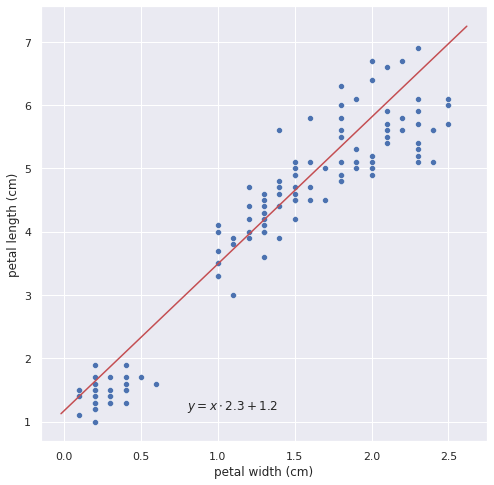

In [437]:
plot_LR(model.ThetaOpt[1],model.ThetaOpt[0])

## Using an automated optimizer

Writing by hand the optimization loops of gradient descent can be quite problematic sometimes (and sometimes boring). That's why sometimes we can use an automated optimizer which requires us just to give the methods for calculating the loss and a gradient. Let's have a look:

In [438]:
import scipy.optimize as sopt
class BFGSLinearRegression:
        
    def __init__(self):
        pass
    
    def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))
    
    def grad(self, Theta, X, y):
        Theta = Theta.reshape(-1,1) #### that's something new, cause bfgs uses different shape
        print(Theta.shape)
        print(X.shape)
        n = X.shape[0]
        E = X @ Theta - y
        return (2./n) * X.T @ E
    
    def loss(self, Theta, X, y):
        Theta = Theta.reshape(-1,1) #### that's something new, cause bfgs uses different shape
        
        n = X.shape[0]
        E = X @ Theta - y
        return (1./n) * E.T @ E
        
    def mse_loss_grad(self, Theta, X, y):
        return self.loss(Theta, X, y), self.grad(Theta, X, y)
    
    def fit(self, X, y):
        X = self.add_ones(X)
        y = np.asarray(y).reshape(-1,1)
        
        Theta0 = np.zeros((X.shape[1], 1)) 

        self.ThetaOpt = sopt.fmin_l_bfgs_b( ### and that's something new
            lambda Theta: self.mse_loss_grad(Theta, X, y), np.array(Theta0))[0]
    
    def predict(self, X):
        return self.add_ones(X) @ self.ThetaOpt

In [439]:

model = BFGSLinearRegression()
model.fit(X,y)
print(model.ThetaOpt)

(2, 1)
(150, 2)
(2, 1)
(150, 2)
(2, 1)
(150, 2)
(2, 1)
(150, 2)
(2, 1)
(150, 2)
(2, 1)
(150, 2)
[1.0835583  2.22994077]


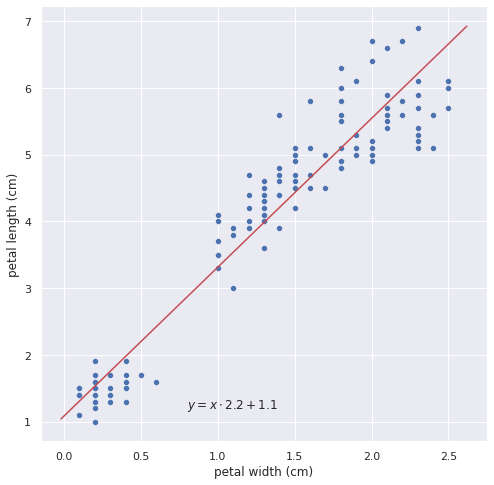

In [440]:
plot_LR(model.ThetaOpt[1],model.ThetaOpt[0])

## Automatic gradient

Writing your own gradient optimization is already quite problematic. Writing your own gradient calculations is even more problematic once your models are even slightly more complicated than linear or logistic regression. That's why it's incredibly convenient to use automatic differentiation. PyTorch, Keras and Tensorflow are the most popular tools for this (although they offer way more than what we are about to see).
When writing simple things like we do, PyTorch is the simplest. So let's check it out.

In [441]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [442]:
import torch 

X_tensor = torch.tensor(np.asarray(X))
y_tensor = torch.tensor(y)

In [443]:
X_tensor

tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.1000],
        [0.2000],
        [0.4000],
        [0.4000],
        [0.3000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.5000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.6000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [1.4000],
        [1.5000],
        [1.5000],
        [1.3000],
        [1.5000],
        [1

In [444]:
y_tensor

tensor([[1.4000],
        [1.4000],
        [1.3000],
        [1.5000],
        [1.4000],
        [1.7000],
        [1.4000],
        [1.5000],
        [1.4000],
        [1.5000],
        [1.5000],
        [1.6000],
        [1.4000],
        [1.1000],
        [1.2000],
        [1.5000],
        [1.3000],
        [1.4000],
        [1.7000],
        [1.5000],
        [1.7000],
        [1.5000],
        [1.0000],
        [1.7000],
        [1.9000],
        [1.6000],
        [1.6000],
        [1.5000],
        [1.4000],
        [1.6000],
        [1.6000],
        [1.5000],
        [1.5000],
        [1.4000],
        [1.5000],
        [1.2000],
        [1.3000],
        [1.4000],
        [1.3000],
        [1.5000],
        [1.3000],
        [1.3000],
        [1.3000],
        [1.6000],
        [1.9000],
        [1.4000],
        [1.6000],
        [1.4000],
        [1.5000],
        [1.4000],
        [4.7000],
        [4.5000],
        [4.9000],
        [4.0000],
        [4.6000],
        [4

In [445]:
X_tensor.shape, y_tensor.shape

(torch.Size([150, 1]), torch.Size([150, 1]))

For extreme simplicity, we don't use the $\Theta$ variable here for the $[1^n,X]$ set, but explicitely we use $a,b$ to model the linear relation $y\sim a\cdot X + b$.

In [446]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(a)
print(b)

tensor([0.4380], requires_grad=True)
tensor([1.4625], requires_grad=True)


The following cell calculates the gradient of Mean Square Error loss in a given point $(a,b)$:

In [447]:
loss = (( X_tensor * a + b - y_tensor)**2).mean() #calculate the loss
loss.backward() #calculate the gradient of all variables that require_grad
with torch.no_grad(): #freeze the computational graph of derivatives
    print(a.grad, b.grad) #print out the gradient

tensor([-6.3144]) tensor([-3.5403])


And that's it. Now we just have to do it in a loop to do the gradient descent.

In [448]:
#usually this function is called `forward` in pytorch context although in ours it was always called `predict`
def model(X): 
    return X * a + b

In [449]:
def mse( y_pred, y_true):
    return torch.mean( (y_pred - y_true)**2)

loss_func = mse

In [450]:
alpha = 0.05

for i in range(1000):
    loss = loss_func(model(X_tensor), y_tensor) # calculate the loss in a given Theta
    loss.backward() #calculate the gradients in a given Theta

    with torch.no_grad(): #turn off gradient calculations to update the gradients
        a -= a.grad * alpha #do the update of gradient descent
        b -= b.grad * alpha
        a.grad.zero_() #zero out the gradients once used
        b.grad.zero_()


In [451]:
Theta = np.asarray( [b.detach().numpy(), a.detach().numpy()]) 
#a and b are still active variables in the computational graph of derivatives
#that's why we need to .detach() before accesing their values

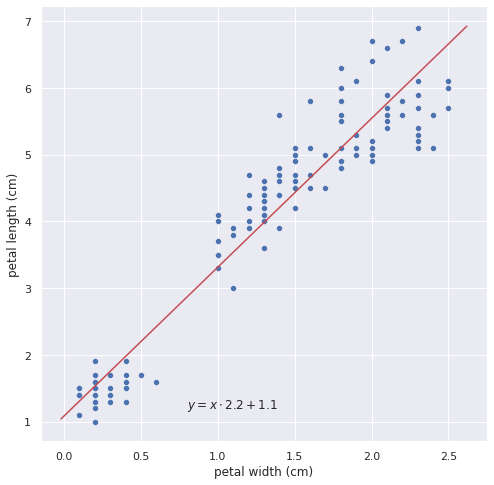

In [452]:
plot_LR(Theta[1], Theta[0])

# MNIST

Remember to use `SoftMax` in all of the below exercises.

In [453]:
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU&confirm=t' -O mnist.npz

with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']
        
# Split train data into train and validation sets
X_trn = mnist_full_train_data_uint8[:50000]
y_trn = mnist_full_train_labels_int64[:50000]
X_tst = mnist_full_train_data_uint8[50000:]
y_tst = mnist_full_train_labels_int64[50000:]

X_trn = X_trn.reshape(-1,28*28)/255
X_tst = X_tst.reshape(-1,28*28)/255

## Problem 1 [2p]

Implement the stochastic gradient descent for MNIST as in `StochasticGradientDescentLinearRegression`. **Remark** it may be better for training to sample not one $x^{\mbox{rand}}$ but a small subset of the $X$ data to get better estimations of the gradient.

In [454]:
def err_rate(pred, test_Y):
    return (pred == test_Y).mean()

In [455]:
class SGDLogicRegression:
  def __init__(self, classes, subsetSize):
      self.k = classes
      self.subsetSize = subsetSize
  
  def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))

  # def softmax(self, X):
  #     X -= np.max(X)
  #     exp = np.exp(X)
  #     print("v1Exp")
  #     # print(exp[0])
  #     print(np.sum(exp, axis=0))
  #     return exp/np.sum(exp, axis = 0)

  def hotEncoding(self, y):
      one_hot = np.zeros((y.shape[0], self.k))
      one_hot[np.arange(len(y)), y] = 1
      return one_hot

  def softmax2(self, X):

    exp = np.exp(X - np.max(X))

    for i in range(X.shape[0]):
        exp[i] /= np.sum(exp[i])

    return exp

  def mse_loss_grad(self, Theta, X, y, hotY):

      rand = np.random.choice(X.shape[0], self.subsetSize)
      randX = X[rand]
      randY = y[rand]
      randHotY = hotY[rand]

      h = self.softmax2(randX @ Theta)
      nll = -np.mean(np.log(h[np.arange(randY.shape[0]), randY]))

      _grad = (1./randX.shape[0]) * randX.T @ (h - randHotY)
      # _grad = randX.T @ (h - self.hotEncoding(randY))
      return nll, _grad


  def fit(self, X, y):
    X = self.add_ones(X)
    Theta = np.zeros((X.shape[1], self.k))
    hotY = self.hotEncoding(y)
    value = np.inf
    alpha = 1e-2

    for _ in tqdm(range(10000)):
      previous_value = value
      value, grad_Theta = self.mse_loss_grad(Theta, X, y, hotY)

      # print(value)
      if np.abs(value-previous_value) < 1e-10:
          break

      Theta = Theta - alpha * grad_Theta

    self.ThetaOpt = Theta

  def predict(self, X):
    return np.argmax(self.add_ones(X) @ self.ThetaOpt, axis=1)

In [456]:
model = SGDLogicRegression(10, 100)
model.fit(X_trn, y_trn)
pred = model.predict(X_tst)
print(err_rate(pred, y_tst))

  0%|          | 0/10000 [00:00<?, ?it/s]

0.9132


## Problem 2 [2p]

Implement the stochastic gradient descent for MNIST as in `BFGSLinearRegression`. Also here calculate the gradient using a subset of the data, and not the whole $X$. Answer the question of how small the size of the subset can roughly be in order to give convergence of the training. Don't give incredibly precise answer, just an order of magnitude is enough: is it 10, 50, 100, 500, 1000?

In [457]:
import scipy.optimize as sopt
class BFGSLogicRegression:
  def __init__(self, classes, subsetSize):
      self.k = classes
      self.subsetSize = subsetSize
  
  def add_ones(self, X):
        return np.hstack((np.ones((X.shape[0],1)), X))

  def hotEncoding(self, y):
      one_hot = np.zeros((y.shape[0], self.k))
      one_hot[np.arange(len(y)), y] = 1
      return one_hot

  def softmax2(self, X):

    exp = np.exp(X - np.max(X))

    for i in range(X.shape[0]):
        exp[i] /= np.sum(exp[i])

    return exp

  def mse_loss_grad(self, Theta, X, y, hotY):

      print(Theta.shape)
      Theta = Theta.reshape(-1,1)
      print(Theta.shape)

      rand = np.random.choice(X.shape[0], self.subsetSize)
      randX = X[rand]
      randY = y[rand]
      randHotY = hotY[rand]
      print(randX.shape)
      h = self.softmax2(randX @ Theta)

      print(h.shape)
      nll = 0
      # nll = -np.mean(np.log(h[np.arange(randY.shape[0]), randY]))

      _grad = (1./randX.shape[0]) * randX.T @ (h - randHotY)
      # _grad = randX.T @ (h - self.hotEncoding(randY))
      return nll, _grad


  def fit(self, X, y):
    X = self.add_ones(X)
    hotY = self.hotEncoding(y)

    Theta0 = np.zeros((X.shape[1], self.k))

    self.ThetaOpt = sopt.fmin_l_bfgs_b( ### and that's something new
            lambda Theta: self.mse_loss_grad(Theta, X, y, hotY), np.array(Theta0))[0]

  def predict(self, X):
    return np.argmax(self.add_ones(X) @ self.ThetaOpt, axis=1)

In [458]:
model = BFGSLogicRegression(10, 1000)
model.fit(X_trn, y_trn)
# print(model.ThetaOpt)
pred = model.predict(X_tst)
# for i in model.ThetaOpt:
#   print(i)
#   print("aaaa")

# print(pred)
# print(y_tst.reshape(-1,))
print(err_rate(pred, y_tst))

(7850,)
(7850, 1)
(1000, 785)


ValueError: ignored

## Problem 3 [2p]


Implement the stochastic gradient descent for MNIST using PyTorch.

In [482]:
# x_trn = torch.tensor(np.asarray(X_trn))
# y_trn = torch.tensor(np.asarray(y_trn))

# x_test = torch.tensor(np.asarray(X_tst))
# y_tst = torch.tensor(np.asarray(y_tst))

In [483]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

In [484]:
a = torch.zeros(x_trn.shape[1], 10, requires_grad=True)
b = torch.zeros(10, requires_grad=True)


def model(X):
    return torch.matmul(X, a) + b

loss_func = torch.nn.CrossEntropyLoss()
alpha = 0.05
optimizer = torch.optim.SGD([a,b], lr=alpha)

for x, y in tqdm(train_loader):
    optimizer.zero_grad()

    x = x.reshape(-1, 28 * 28)
    loss = loss_func(model(x), y)
    loss.backward()
    optimizer.step()
  


  0%|          | 0/600 [00:00<?, ?it/s]

In [485]:
score = 0
with torch.no_grad():
    for x, y in tqdm(test_loader):
      x = x.reshape(-1, 28 * 28)
      preds = torch.argmax(model(x), dim=1)
      score += torch.sum(preds == y)

print(score/len(mnist_test))      

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.8925)
